# TabNet

TabNet is a deep learning model used for processing tabular data. It uses sequential attention to select the infpormative features at each step, making it an inherently interpretable model [1]. For more information, you can refer to [this paper](https://arxiv.org/pdf/1908.07442.pdf).

In [2]:
# installing required packages
%pip install imbalanced-learn
%pip install pytorch_tabnet

     --------------------------------------- 238.4/238.4 kB 6.1 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /fs01/projects/aieng/public/interp_bootcamp/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl (44 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /fs01/projects/aieng/public/interp_bootcamp/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb

### Data
The dataset used in this notebook is US-130, which contains different  clinical measurements related to patients diagnosed with diabetes from 1999-2008. To find more information about this dataset, you can refer to [this link](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008).

In [4]:
# preprocessing function
def process_us_130_csv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function for new data downloaded from UCL
    """
    age_transform = { '[0-10)' : 5,
                      '[10-20)' : 15,
                      '[20-30)' : 25,
                      '[30-40)' : 35,
                      '[40-50)' : 45,
                      '[50-60)' : 55,
                      '[60-70)' : 65,
                      '[70-80)' : 75,
                      '[80-90)' : 85,
                      '[90-100)' : 95
                    }
    
    #Apply column specific transformations
    df['age'] = df['age'].apply(lambda x : age_transform[x])
    df['diag_1'] = df['diag_1'].apply(lambda x: x[:x.find(".")])
    df['diag_2'] = df['diag_2'].apply(lambda x: x[:x.find(".")])
    df['diag_3'] = df['diag_3'].apply(lambda x: x[:x.find(".")])
    df['readmitted_binarized'] = df['readmitted'].apply(lambda x: 1 if x=='<30' else 0)
    df['max_glu_serum'] = df['max_glu_serum'].apply(lambda x: 'Unknown' if type(x) != str else x)
    df['A1Cresult'] = df['A1Cresult'].apply(lambda x: 'Unknown' if type(x) != str else x)

    #Drop columns which are not needed
    df = df.drop(['encounter_id', 'patient_nbr', 'examide',
                  'readmitted','weight','payer_code', 'medical_specialty'], axis=1)

    #Frequency encoding of categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()    
    for cat_column in categorical_columns:
        frequency_encoding = df[cat_column].value_counts(normalize=True).to_dict()
        df[f'encoded_{cat_column}'] = df[cat_column].map(frequency_encoding)
        df = df.drop(cat_column, axis=1)

    return df

In [5]:
# data loading and preparation
data = pd.read_csv("diabetic_data.csv")
df = process_us_130_csv(data)
df.index=range(df.shape[0])
X , y = df.drop("readmitted_binarized",axis=1) , df["readmitted_binarized"]
    
k = 5
indices = np.arange(len(X))
np.random.shuffle(indices)
folds = np.array_split(indices, k)


### Model Training

In [7]:
auc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

for i in range(k):
    test_idx = folds[i]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Use all other folds as the training set
    train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    clf = TabNetClassifier()

    clf.fit(X_train.values, y_train.values,max_epochs=20)
    y_pred = clf.predict(X_test.values)

    y_prob = clf.predict_proba(X_test.values)[:,1]

    test_auc = roc_auc_score(y_test, y_prob)
    test_f1 = f1_score(y_test,y_pred)
    test_precision = precision_score(y_test,y_pred)
    test_recall = recall_score(y_test,y_pred)
    
    print("test_auc",test_auc)
    print("test_f1",test_f1)
    print("test_precision",test_precision)
    print("test_recall",test_recall)

/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.39603 |  0:00:05s
epoch 1  | loss: 0.3483  |  0:00:09s
epoch 2  | loss: 0.34488 |  0:00:13s
epoch 3  | loss: 0.34153 |  0:00:17s
epoch 4  | loss: 0.34111 |  0:00:21s
epoch 5  | loss: 0.33897 |  0:00:25s
epoch 6  | loss: 0.33845 |  0:00:29s
epoch 7  | loss: 0.33709 |  0:00:33s
epoch 8  | loss: 0.3368  |  0:00:37s
epoch 9  | loss: 0.33612 |  0:00:41s
epoch 10 | loss: 0.33586 |  0:00:45s
epoch 11 | loss: 0.33644 |  0:00:48s
epoch 12 | loss: 0.336   |  0:00:52s
epoch 13 | loss: 0.3348  |  0:00:56s
epoch 14 | loss: 0.33485 |  0:01:00s
epoch 15 | loss: 0.3342  |  0:01:04s
epoch 16 | loss: 0.33411 |  0:01:08s
epoch 17 | loss: 0.33397 |  0:01:12s
epoch 18 | loss: 0.33365 |  0:01:16s
epoch 19 | loss: 0.33388 |  0:01:19s
val_auc 0.6313278053253725
val_f1 0.021123785382340516
val_precision 0.7352941176470589
val_recall 0.010715816545220747


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.39478 |  0:00:03s
epoch 1  | loss: 0.34518 |  0:00:07s
epoch 2  | loss: 0.34227 |  0:00:11s
epoch 3  | loss: 0.34103 |  0:00:15s
epoch 4  | loss: 0.34028 |  0:00:19s
epoch 5  | loss: 0.33908 |  0:00:23s
epoch 6  | loss: 0.33919 |  0:00:27s
epoch 7  | loss: 0.33891 |  0:00:30s
epoch 8  | loss: 0.33802 |  0:00:34s
epoch 9  | loss: 0.3378  |  0:00:38s
epoch 10 | loss: 0.33723 |  0:00:42s
epoch 11 | loss: 0.3375  |  0:00:46s
epoch 12 | loss: 0.33699 |  0:00:49s
epoch 13 | loss: 0.33675 |  0:00:53s
epoch 14 | loss: 0.33699 |  0:00:58s
epoch 15 | loss: 0.3375  |  0:01:01s
epoch 16 | loss: 0.33801 |  0:01:05s
epoch 17 | loss: 0.33656 |  0:01:09s
epoch 18 | loss: 0.33635 |  0:01:13s
epoch 19 | loss: 0.33631 |  0:01:17s
val_auc 0.6365576665148684
val_f1 0.015577672003461706
val_precision 0.5625
val_recall 0.007898200965335674


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.40031 |  0:00:03s
epoch 1  | loss: 0.3502  |  0:00:08s
epoch 2  | loss: 0.34968 |  0:00:11s
epoch 3  | loss: 0.34868 |  0:00:15s
epoch 4  | loss: 0.34721 |  0:00:19s
epoch 5  | loss: 0.3436  |  0:00:23s
epoch 6  | loss: 0.3413  |  0:00:27s
epoch 7  | loss: 0.34079 |  0:00:31s
epoch 8  | loss: 0.33987 |  0:00:35s
epoch 9  | loss: 0.33886 |  0:00:39s
epoch 10 | loss: 0.3382  |  0:00:42s
epoch 11 | loss: 0.33848 |  0:00:47s
epoch 12 | loss: 0.33827 |  0:00:50s
epoch 13 | loss: 0.33724 |  0:00:54s
epoch 14 | loss: 0.33858 |  0:00:58s
epoch 15 | loss: 0.3381  |  0:01:02s
epoch 16 | loss: 0.33765 |  0:01:06s
epoch 17 | loss: 0.33732 |  0:01:10s
epoch 18 | loss: 0.33778 |  0:01:14s
epoch 19 | loss: 0.33653 |  0:01:18s
val_auc 0.6520331114288654
val_f1 0.01559792027729636
val_precision 0.3673469387755102
val_recall 0.00796812749003984


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.40022 |  0:00:03s
epoch 1  | loss: 0.34892 |  0:00:07s
epoch 2  | loss: 0.34384 |  0:00:11s
epoch 3  | loss: 0.34349 |  0:00:15s
epoch 4  | loss: 0.34158 |  0:00:19s
epoch 5  | loss: 0.3412  |  0:00:23s
epoch 6  | loss: 0.34077 |  0:00:27s
epoch 7  | loss: 0.34122 |  0:00:31s
epoch 8  | loss: 0.34083 |  0:00:35s
epoch 9  | loss: 0.33967 |  0:00:39s
epoch 10 | loss: 0.34025 |  0:00:43s
epoch 11 | loss: 0.34053 |  0:00:47s
epoch 12 | loss: 0.34151 |  0:00:50s
epoch 13 | loss: 0.34023 |  0:00:54s
epoch 14 | loss: 0.33936 |  0:00:58s
epoch 15 | loss: 0.33795 |  0:01:02s
epoch 16 | loss: 0.33756 |  0:01:06s
epoch 17 | loss: 0.33667 |  0:01:10s
epoch 18 | loss: 0.33693 |  0:01:14s
epoch 19 | loss: 0.33678 |  0:01:17s
val_auc 0.641366726540331
val_f1 0.012400354295837024
val_precision 0.4827586206896552
val_recall 0.006280843427545985


/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.40179 |  0:00:03s
epoch 1  | loss: 0.34947 |  0:00:07s
epoch 2  | loss: 0.34718 |  0:00:11s
epoch 3  | loss: 0.34524 |  0:00:15s
epoch 4  | loss: 0.34256 |  0:00:19s
epoch 5  | loss: 0.34198 |  0:00:23s
epoch 6  | loss: 0.34104 |  0:00:27s
epoch 7  | loss: 0.34058 |  0:00:31s
epoch 8  | loss: 0.33968 |  0:00:35s
epoch 9  | loss: 0.33898 |  0:00:39s
epoch 10 | loss: 0.33887 |  0:00:42s
epoch 11 | loss: 0.33781 |  0:00:46s
epoch 12 | loss: 0.33809 |  0:00:50s
epoch 13 | loss: 0.33769 |  0:00:54s
epoch 14 | loss: 0.33788 |  0:00:58s
epoch 15 | loss: 0.33705 |  0:01:02s
epoch 16 | loss: 0.33734 |  0:01:06s
epoch 17 | loss: 0.33733 |  0:01:10s
epoch 18 | loss: 0.33786 |  0:01:13s
epoch 19 | loss: 0.33733 |  0:01:17s
val_auc 0.6345957238057296
val_f1 0.010530934620447565
val_precision 0.5454545454545454
val_recall 0.005316792202038104


### Global and Local Explainability:

Global explainability refers to the features important to the whole model, while local explainability demonstrates the features determining in a specific prediction for a datapoint.





In [24]:
# global explainabilit
# Convert feature importances to a DataFrame
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": clf.feature_importances_})

# Sort by importance values in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the sorted values
print(importance_df)

                             Feature    Importance
7                    num_medications  2.228174e-01
9                   number_emergency  1.852215e-01
13                    encoded_gender  1.027671e-01
14                    encoded_diag_1  1.022794e-01
36       encoded_glyburide-metformin  8.172681e-02
10                  number_inpatient  7.455804e-02
5                 num_lab_procedures  5.718026e-02
2           discharge_disposition_id  3.119576e-02
30                  encoded_acarbose  2.794865e-02
28              encoded_pioglitazone  2.145266e-02
39   encoded_metformin-rosiglitazone  2.060531e-02
25                 encoded_glipizide  1.894079e-02
12                      encoded_race  1.076436e-02
6                     num_procedures  1.072566e-02
19                 encoded_metformin  6.719661e-03
4                   time_in_hospital  6.644800e-03
23               encoded_glimepiride  5.277466e-03
38  encoded_glimepiride-pioglitazone  4.017655e-03
11                  number_diag

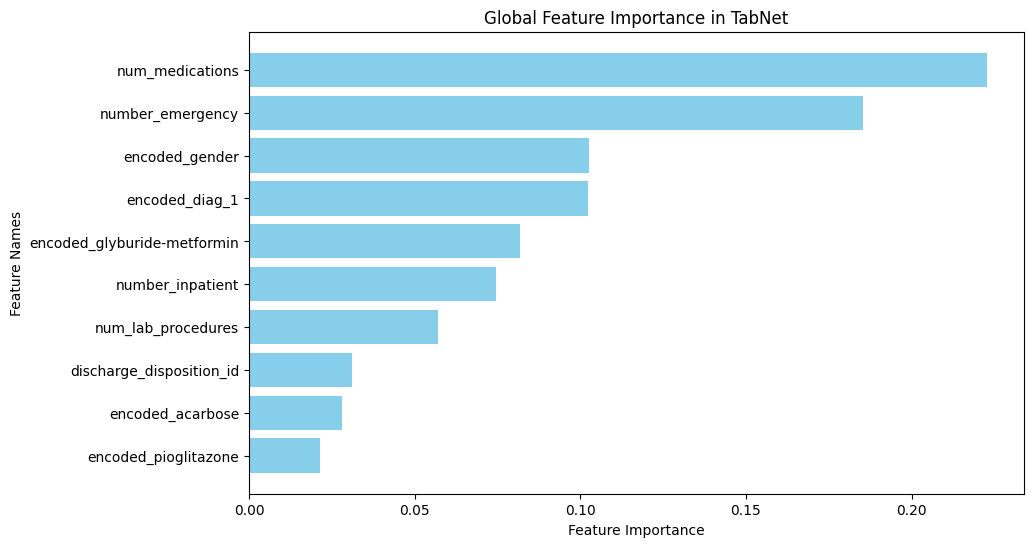

In [25]:
# Plot the most important features
importance_df = importance_df.nlargest(10, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Global Feature Importance in TabNet")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
plt.show()

As can be observed "num_medications", "number_emergency", and "encoded_gender" have been identified as the most important global features by TabNet. 

In [10]:
# local explainability
explain_matrix, masks = clf.explain(np.array(X_test))

In [15]:

# Select an instance to visualize (e.g., first sample)
instance_idx = 0  
local_importance = explain_matrix[instance_idx]

# Create DataFrame for sorting
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": local_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the sorted feature importance for the selected instance
print(importance_df)

                             Feature  Importance
13                    encoded_gender    1.812479
28              encoded_pioglitazone    1.601527
25                 encoded_glipizide    0.969379
3                admission_source_id    0.000000
4                   time_in_hospital    0.000000
5                 num_lab_procedures    0.000000
6                     num_procedures    0.000000
7                    num_medications    0.000000
0                                age    0.000000
1                  admission_type_id    0.000000
2           discharge_disposition_id    0.000000
10                  number_inpatient    0.000000
9                   number_emergency    0.000000
8                  number_outpatient    0.000000
12                      encoded_race    0.000000
15                    encoded_diag_2    0.000000
16                    encoded_diag_3    0.000000
17             encoded_max_glu_serum    0.000000
11                  number_diagnoses    0.000000
18                 e

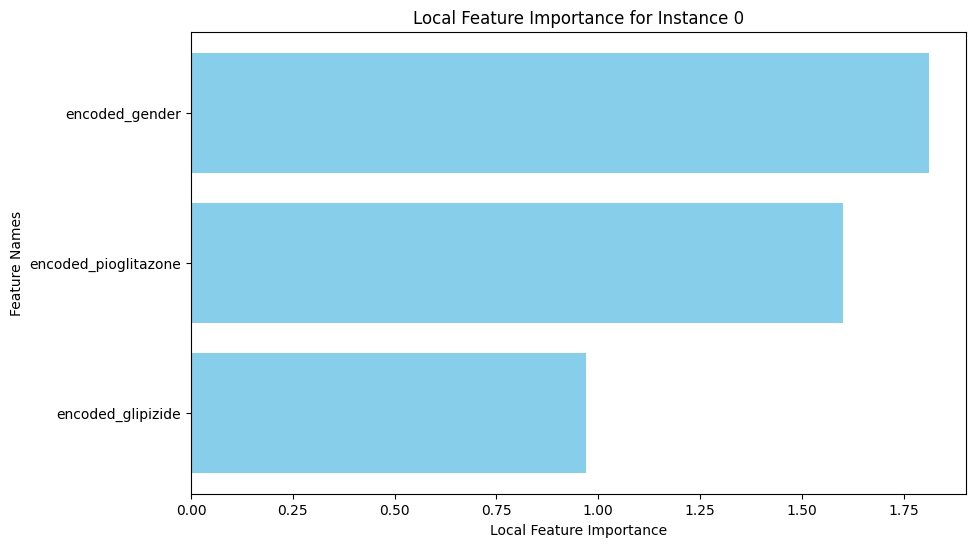

In [22]:
importance_df = importance_df.nlargest(3, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Local Feature Importance")
plt.ylabel("Feature Names")
plt.title(f"Local Feature Importance for Instance {instance_idx}")
plt.gca().invert_yaxis()  # Show most important features at the top
plt.show()

As can be observed "encoded_gender", "encoded_pioglitazone", and "encoded_glipizide" have been identified as the most important local features for the first datapoint by TabNet. 

# Comparison with XGBoost

In [31]:
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Use "multi:softmax" for multi-class
    eval_metric="logloss",        # Choose appropriate evaluation metric
    use_label_encoder=False,      # Avoid warning in newer versions
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    subsample=0.8,                # Fraction of samples per tree
    colsample_bytree=0.8,         # Fraction of features per tree
    random_state=42
)

xgb_clf.fit(X_train, y_train)

/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [33]:
test_probs = np.array(xgb_clf.predict_proba(X_test))
test_preds = clf.predict(X_test.values)
test_auc = roc_auc_score(y_score=test_probs[:,1], y_true=y_test)
test_f1 = f1_score(y_test,test_preds)
test_precision = precision_score(y_test,test_preds)
test_recall = recall_score(y_test,test_preds)
print("test_auc",test_auc)
print("test_f1",test_f1)
print("test_precision",test_precision)
print("test_recall",test_recall)

test_auc 0.6750229514856423
test_f1 0.02339688041594454
test_precision 0.5294117647058824
test_recall 0.011962782454585734


In [36]:
# XGB Feature Importance
# Extract feature importances 
importance_df = pd.DataFrame({
    "Feature": X_train.columns, 
    "Importance": clf.feature_importances_
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)


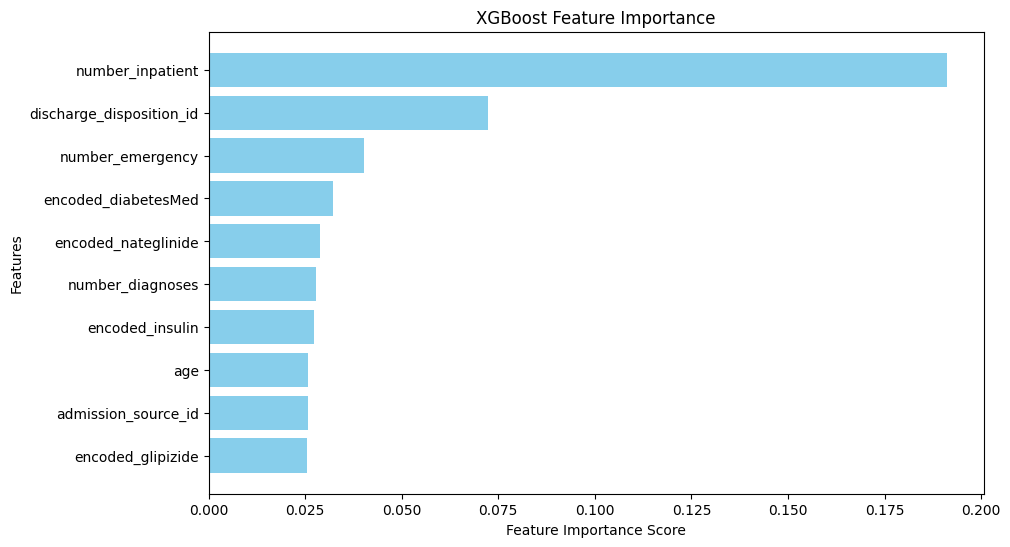

In [38]:
importance_df = importance_df.nlargest(10, "Importance")
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

As can be observed "number_inpatient", "discharge_disposition_id", and "number_emergency" have been identified as the most important features by the XGBoost model.

## References

[1] https://arxiv.org/pdf/1908.07442.pdf